<a href="https://colab.research.google.com/github/AkuaAmofa/Study_Buddy/blob/main/Copy_of_AIFinalProject4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded.keys())))
print("Dataset loaded. Shape:", df.shape)
df.head()

Saving dataset.csv to dataset (1).csv
Dataset loaded. Shape: (776, 34)


,game_number,game_type,player_id,year_group,player_name,position,team,team_score,opponent,opponent_score,...,fg_pct,three_pt_pct,ft_pct,reb,ast,stl,blk,fouls,pts,efficiency
0,1,Regular Season,1,2026,Benson Kas-Vorsah,SG,Ashknights,59,Longshots,52,...,25,20,50,8.0,1.0,1.0,0.0,1.0,8,13.0
1,1,Regular Season,2,2025,Elton Gamor,SF,Ashknights,59,Longshots,52,...,50,100,25,10.0,2.0,1.0,0.0,4.0,18,25.0
2,1,Regular Season,3,2026,Sean Yeboah,C,Ashknights,59,Longshots,52,...,57.14,66.67,85.71,19.0,2.0,0.0,1.0,2.0,16,42.0
3,1,Regular Season,4,2026,Trueman Mabumbo,PG,Ashknights,59,Longshots,52,...,18.18,0,50,2.0,2.0,0.0,0.0,3.0,5,-1.0
4,1,Regular Season,5,2027,Alex Yeboah,PF,Ashknights,59,Longshots,52,...,No shots attempted,No shots attempted,No shots attempted,NaN,NaN,NaN,NaN,NaN,0,NaN


In [ ]:
def preprocess_percentage_columns(df, percentage_columns):
    for col in percentage_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    return df

def calculate_derived_stats(df):
    df = df.copy()
    df['fg_made'] = df['two_pt_make'] + df['three_pt_make']
    df['fg_miss'] = df['two_pt_miss'] + df['three_pt_miss']
    df['fg_attempts'] = df['fg_made'] + df['fg_miss']
    df['fg_pct'] = np.round(np.where(df['fg_attempts'] > 0, (df['fg_made'] / df['fg_attempts']) * 100, 0), 1)
    df['three_pt_pct'] = np.round(np.where(
        (df['three_pt_make'] + df['three_pt_miss']) > 0,
        (df['three_pt_make'] / (df['three_pt_make'] + df['three_pt_miss'])) * 100, 0), 1)
    df['ft_pct'] = np.round(np.where(
        (df['ft_make'] + df['ft_miss']) > 0,
        (df['ft_make'] / (df['ft_make'] + df['ft_miss'])) * 100, 0), 1)
    df['pts'] = df['two_pt_make'] * 2 + df['three_pt_make'] * 3 + df['ft_make']
    return df

In [ ]:
df = df[df['year_group'] != 2025]
print("Players by year_group after filtering:\n", df['year_group'].value_counts())

Players by year_group after filtering:
 year_group
2028    317
2027    191
2026    124
Name: count, dtype: int64


In [ ]:
import math

class BasketballEloSystem:
    def __init__(self, k_factor=24, initial_rating=1000, home_advantage=50, regression_factor=0.75):
        self.k_factor = k_factor
        self.initial_rating = initial_rating
        self.home_advantage = home_advantage
        self.regression_factor = regression_factor
        self.team_ratings = {}
        self.player_ratings = {}
        self.team_rating_history = {}
        self.player_rating_history = {}
        self.player_names = {}

    def initialize_player_ratings(self, season_data):
        unique_players = season_data[['player_id', 'player_name', 'year_group']].drop_duplicates('player_id')
        for _, row in unique_players.iterrows():
            player_id = row['player_id']
            self.player_ratings[player_id] = self.initial_rating
            self.player_rating_history[player_id] = [self.initial_rating]
            self.player_names[player_id] = row['player_name']
        for team in season_data['team'].unique():
            self.team_ratings[team] = self.initial_rating
            self.team_rating_history[team] = [self.initial_rating]



In [ ]:
def train_best_model(historical_data, features, target):
    historical_data = historical_data.fillna(historical_data.mean(numeric_only=True))
    X = historical_data[features]
    y = historical_data[target]
    common_indices = X.index.intersection(y.index)
    X = X.loc[common_indices]
    y = y.loc[common_indices]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42)
    }
    best_model = None
    best_r2 = float('-inf')
    for name, model in models.items():
        model.fit(X_train, y_train)
        r2 = r2_score(y_test, model.predict(X_test))
        if r2 > best_r2:
            best_r2 = r2
            best_model = model
    return best_model

In [ ]:
def generate_schedule(teams):
    schedule = []
    for i in range(len(teams)):
        for j in range(len(teams)):
            if i != j:
                schedule.append((teams[i], teams[j]))
    return schedule

In [ ]:
percentage_columns = ['fg_pct', 'three_pt_pct', 'ft_pct']
df = preprocess_percentage_columns(df, percentage_columns)
df = calculate_derived_stats(df)

features = ['reb', 'ast', 'stl', 'blk', 'fouls']
targets = [
    'two_pt_make', 'two_pt_miss', 'three_pt_make', 'three_pt_miss',
    'ft_make', 'ft_miss', 'reb', 'ast', 'stl', 'blk', 'fouls'
]

In [ ]:
models = {}
for target in targets:
    models[target] = train_best_model(df, features, target)
print("All models trained.")

All models trained.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

performance_summary = []

for target in targets:
    historical_data = df.fillna(df.mean(numeric_only=True))
    X = historical_data[features]
    y = historical_data[target]
    common_indices = X.index.intersection(y.index)
    X = X.loc[common_indices]
    y = y.loc[common_indices]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_model = None
    best_r2 = float('-inf')
    best_model_name = ""
    best_mse = float('inf')

    # Test all models for each stat and collect performance metrics
    for name, model in {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42)
    }.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        if r2 > best_r2:
            best_r2 = r2
            best_model = model
            best_model_name = name
            best_mse = mse

    performance_summary.append({
        "Stat": target,
        "Best Model": best_model_name,
        "R²": round(best_r2, 3),
        "MSE": round(best_mse, 3)
    })

performance_df = pd.DataFrame(performance_summary)
performance_df

,Stat,Best Model,R²,MSE
0,two_pt_make,Random Forest,0.431,2.047
1,two_pt_miss,Ridge Regression,0.131,2.495
2,three_pt_make,Ridge Regression,0.068,0.438
3,three_pt_miss,Linear Regression,0.102,3.758
4,ft_make,Random Forest,0.116,0.771
5,ft_miss,Ridge Regression,-0.001,1.022
6,reb,Linear Regression,1.000,0.000
7,ast,Linear Regression,1.000,0.000
8,stl,Linear Regression,1.000,0.000
9,blk,Linear Regression,1.000,0.000


In [ ]:
elo_system = BasketballEloSystem()
elo_system.initialize_player_ratings(df)
teams = df['team'].unique().tolist()
schedule = generate_schedule(teams)
player_info = df[['player_id', 'player_name', 'year_group']].drop_duplicates()
simulated_games = []
game_number = 1

for home_team, away_team in schedule:
    game_players = []
    # Home team players
    for player_id in df[df['team'] == home_team]['player_id'].unique():
        row = df[df['player_id'] == player_id].iloc[0]
        stats = {
            'game_number': game_number,
            'player_id': player_id,
            'player_name': row['player_name'],
            'team': home_team,
            'opponent': away_team,
            'is_home': True,
            'year_group': row['year_group']
        }
        for target in targets:
            feature_vals = row[features].fillna(0)
            pred = models[target].predict(feature_vals.to_frame().T)[0]
            stats[target] = int(max(0, np.round(pred)))
        game_players.append(stats)
    # Away team players
    for player_id in df[df['team'] == away_team]['player_id'].unique():
        row = df[df['player_id'] == player_id].iloc[0]
        stats = {
            'game_number': game_number,
            'player_id': player_id,
            'player_name': row['player_name'],
            'team': away_team,
            'opponent': home_team,
            'is_home': False,
            'year_group': row['year_group']
        }
        for target in targets:
            feature_vals = row[features].fillna(0)
            pred = models[target].predict(feature_vals.to_frame().T)[0]
            stats[target] = int(max(0, np.round(pred)))
        game_players.append(stats)
    # --- Calculate game-level outcomes ---
    game_df = pd.DataFrame(game_players)
    game_df['pts'] = (2 * game_df['two_pt_make']) + (3 * game_df['three_pt_make']) + game_df['ft_make']
    home_score = game_df[game_df['team'] == home_team]['pts'].sum()
    away_score = game_df[game_df['team'] == away_team]['pts'].sum()
    # Optionally break ties randomly
    if home_score == away_score:
        if np.random.rand() > 0.5:
            home_score += 1
        else:
            away_score += 1
    game_df['team_score'] = np.where(game_df['team'] == home_team, home_score, away_score)
    game_df['opponent_score'] = np.where(game_df['team'] == home_team, away_score, home_score)
    game_df['game_outcome'] = np.where(
        ((game_df['team'] == home_team) & (home_score > away_score)) |
        ((game_df['team'] == away_team) & (away_score > home_score)),
        'Won', 'Lost')
    game_df['winner'] = home_team if home_score > away_score else away_team
    simulated_games.append(game_df)
    game_number += 1

simulated_df = pd.concat(simulated_games, ignore_index=True)
simulated_df = calculate_derived_stats(simulated_df)

In [ ]:
simulated_df.to_excel("next_season_simulated_stats.xlsx", index=False)
from google.colab import files
files.download("next_season_simulated_stats.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

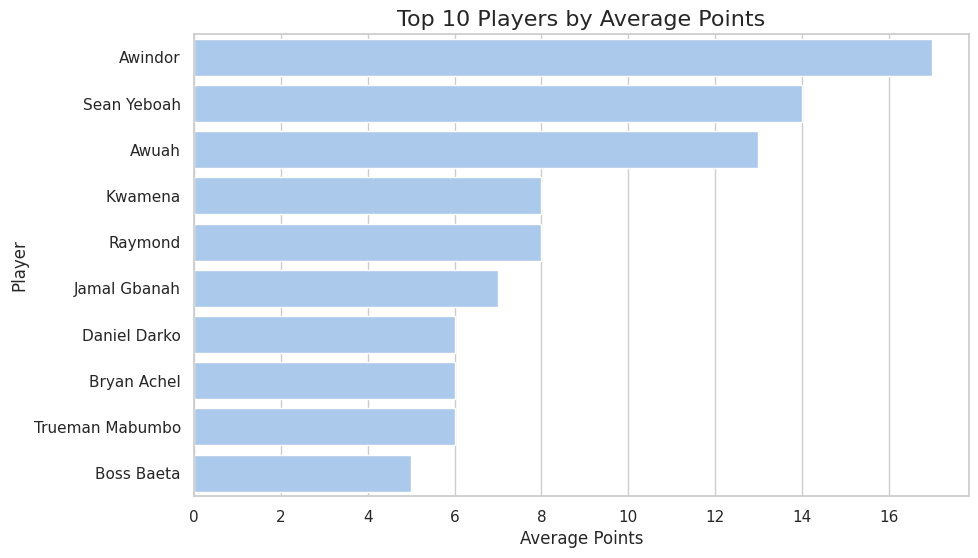

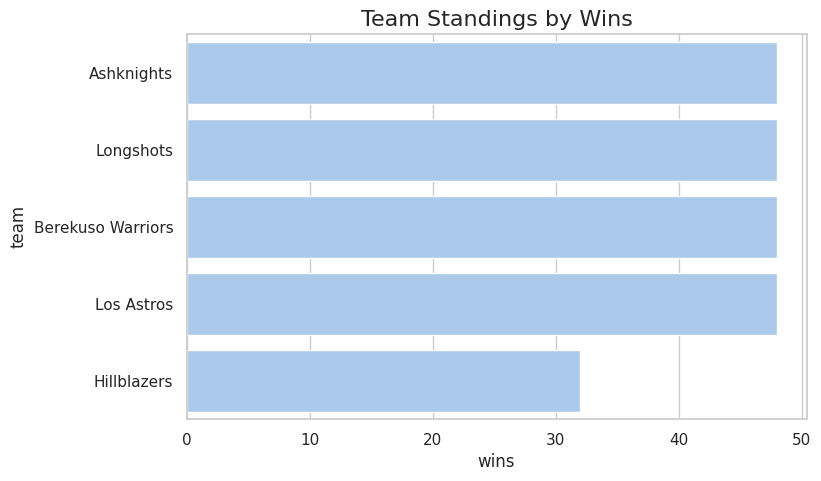

In [ ]:
# Top Players by Average Points
top_players = simulated_df.groupby('player_name')['pts'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_players.values, y=top_players.index)
plt.title("Top 10 Players by Average Points")
plt.xlabel("Average Points")
plt.ylabel("Player")
plt.show()

# Team Standings Plot
plt.figure(figsize=(8,5))
sns.barplot(x='wins', y='team', data=standings)
plt.title("Team Standings by Wins")
plt.show()